In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import h5py
import pickle
import json
import torch
from tqdm import tqdm, tqdm_notebook

from performance import *
from pycit import *
from bullseye import bullseye_network, get_ci_dict
from mapping import ModelManager

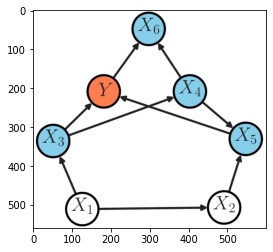

In [2]:
# make data with illustrated DAG structure
num_samples = 5000 
dim = 3
r_data, x_data, y_data = bullseye_network(num_samples, dim, eps=0.075)
r_data = standardize(r_data.astype(np.float16))
x_data = standardize(x_data.astype(np.float16))
y_data = standardize(y_data.astype(np.float16))

np.save("data/bullseye3dY.npy", y_data)
np.save("data/bullseye3dX.npy", x_data)

# plot dag structure
plt.figure()
plt.imshow(mpimg.imread('assets/dag7.png'))
plt.show()

## learn feature mappings

Validation performance didn't improve for 50 epochs. Training stops.


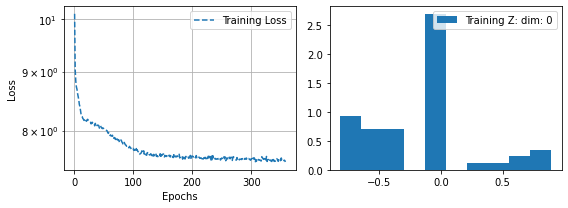

In [3]:
config_path = "config/bullseye3d.json"
manager = ModelManager(config_path, make_plots=True)
manager.train()

## load learned feature mappings

In [4]:
manager.load_model(checkpoint_file="model_best.pth")
mu,lv,z = manager.process_numpy(x_data)
z_data = standardize(z)

## set cit settings

In [5]:
CONFIDENCE_LEVEL = 0.95
K_KNN = 5
K_PERM = 5
SUBSAMPLE_SIZE = None
N_TRIALS = 250
N_JOBS = 4

cit_funcs = {
    'it_args': {
        'statistic_args': {
            'k': K_KNN
        },
        'test_args': {
            'statistic': 'mixed_mi',
            'k_perm': K_PERM,
            'subsample_size': SUBSAMPLE_SIZE,
            'n_trials': N_TRIALS,
            'n_jobs': N_JOBS
        }
    },
    'cit_args': {
        'statistic_args': {
            'k': K_KNN
        },
        'test_args': {
            'statistic': 'mixed_cmi',
            'k_perm': K_PERM,
            'subsample_size': SUBSAMPLE_SIZE,
            'n_trials': N_TRIALS,
            'n_jobs': N_JOBS
        }
    }
}

## find Markov blanket using original X data

* The algorithm fails to find the correct Markov Blanket

In [6]:
mb = MarkovBlanket(x_data, y_data, cit_funcs)
selected = mb.find_markov_blanket(confidence=CONFIDENCE_LEVEL, verbose=True)

==========Finding Adjacents...==========
Testing X_{6}
  Cond. set: []
    Is CI: False, pval: 0.000
Testing X_{4}
  Cond. set: []
    Is CI: False, pval: 0.000
Testing X_{1}
  Cond. set: []
    Is CI: False, pval: 0.000
Testing X_{2}
  Cond. set: []
    Is CI: False, pval: 0.000
Testing X_{3}
  Cond. set: []
    Is CI: False, pval: 0.000
Testing X_{5}
  Cond. set: []
    Is CI: False, pval: 0.000
Testing X_{6}
  Cond. set: ['X_{3}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{1}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{4}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{5}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{2}']
    Is CI: False, pval: 0.000
Testing X_{4}
  Cond. set: ['X_{2}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{5}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{1}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{6}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{3}']
    Is CI: False, pval: 0.000
Testing X_{1}
  Cond. set: ['X_{6}']
    

## find Markov blanket using mapped features

* The algorithm finds the correct Markov Blanket

In [7]:
mb = MarkovBlanket(z_data, y_data, cit_funcs)
selected = mb.find_markov_blanket(confidence=CONFIDENCE_LEVEL, verbose=True)

==========Finding Adjacents...==========
Testing X_{5}
  Cond. set: []
    Is CI: False, pval: 0.000
Testing X_{3}
  Cond. set: []
    Is CI: False, pval: 0.000
Testing X_{2}
  Cond. set: []
    Is CI: False, pval: 0.000
Testing X_{6}
  Cond. set: []
    Is CI: False, pval: 0.000
Testing X_{1}
  Cond. set: []
    Is CI: False, pval: 0.000
Testing X_{4}
  Cond. set: []
    Is CI: False, pval: 0.000
Testing X_{5}
  Cond. set: ['X_{3}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{4}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{6}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{2}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{1}']
    Is CI: False, pval: 0.000
Testing X_{3}
  Cond. set: ['X_{5}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{1}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{6}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{4}']
    Is CI: False, pval: 0.000
  Cond. set: ['X_{2}']
    Is CI: False, pval: 0.000
Testing X_{2}
  Cond. set: ['X_{3}']
    